In [21]:
import numpy as np
import pandas as pd
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql import functions as f

spark = SparkSession.builder.enableHiveSupport().getOrCreate()

# Suppresses user warinig messages in Python
import warnings
warnings.simplefilter("ignore", UserWarning)

# Suppresses `WARN` messages in JVM
spark.sparkContext.setLogLevel("ERROR")

In [22]:
import importlib
ptesting_model = importlib.import_module("ptesting-model")

In [23]:
expected_input_cols = [                                                                                                                                                                                                                       
    'author',
    'case when length(sha) > 0 then sha else sha(string(random())) end sha',
    'commit_date',
    'array_distinct(failed_tests) failed_tests',
    'files' 
]

log_data_df = spark.read.format('json').load('../models/spark/logs/github-logs.json').selectExpr(expected_input_cols)

In [24]:
log_data_df.orderBy(f.expr('commit_date').desc()).show(3)

+------------+--------------------+-------------------+--------------------+--------------------+
|      author|                 sha|        commit_date|        failed_tests|               files|
+------------+--------------------+-------------------+--------------------+--------------------+
|         c21|9b8b9ef7efa3ab055...|2021/10/26 23:36:54|                  []|[{{10, 10, 0, sql...|
|     xkrogen|bfb98833ddd60db80...|2021/10/26 22:16:21|                  []|[{{9, 18, 9, core...|
|AngersZhuuuu|d03a64cf0b4e5e303...|2021/10/26 14:17:48|[org.apache.spark...|[{{288, 288, 0, s...|
+------------+--------------------+-------------------+--------------------+--------------------+
only showing top 3 rows



In [25]:
import json
from pathlib import Path 
excluded_tests = json.loads(Path('../models/spark/logs/excluded-tests.json').read_text())
log_data_df = ptesting_model._exclude_tests_from(log_data_df, excluded_tests)

In [26]:
from ptesting import github_utils

test_files = json.loads(Path('../models/spark/indexes/latest/test-files.json').read_text())
commits = json.loads(Path('../models/spark/logs/commits.json').read_text())
commits = list(map(lambda c: github_utils.from_github_datetime(c[0]), commits))
updated_file_stats = json.loads(Path('../models/spark/logs/updated-file-stats.json').read_text())
failed_tests = json.loads(Path('../models/spark/failed-tests.json').read_text())
contributor_stats = json.loads(Path('../models/spark/logs/contributor-stats.json').read_text())
dep_graph = json.loads(Path('../models/spark/indexes/latest/dep-graph.json').read_text())

In [27]:
to_train_features, to_test_features = ptesting_model._create_train_test_pipeline(spark, test_files, commits, dep_graph, updated_file_stats, contributor_stats, failed_tests)

In [28]:
train_df, test_df = ptesting_model._train_test_split(log_data_df, test_ratio=0.10)

In [29]:
pdf = to_train_features(train_df).cache().toPandas()
pdf

,failed,num_commits,updated_num_3d,updated_num_14d,updated_num_56d,updated_num_3c,updated_num_14c,updated_num_56c,num_adds,num_dels,...,failed_num_7d__x__num_chgs,failed_num_7d__x__updated_num_56d,failed_num_7d__x__updated_num_56c,failed_num_7d__x__path_difference,failed_num_7d__x__distance,distance__x__num_commits,distance__x__num_chgs,distance__x__updated_num_56d,distance__x__updated_num_56c,distance__x__path_difference
0,0,0,0,0,0,0,0,0,47,70,...,0,0,0,0,0,0,117,0,0,5
1,0,0,0,0,0,0,0,0,47,70,...,0,0,0,0,0,0,0,0,0,0
2,0,221,1,3,18,0,0,1,976,33,...,0,0,0,0,0,221,1009,18,1,7
3,0,221,1,3,18,0,0,1,976,33,...,0,0,0,0,0,221,1009,18,1,5
4,0,221,1,3,18,0,0,1,976,33,...,0,0,0,0,0,442,2018,36,2,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139166,1,634,0,3,17,0,0,3,58,20,...,0,0,0,0,0,634,78,17,3,3
139167,1,634,0,3,17,0,0,3,58,20,...,234,51,9,15,6,1268,156,34,6,10
139168,1,634,0,3,17,0,0,3,58,20,...,0,0,0,0,0,0,0,0,0,0
139169,1,221,0,3,43,0,0,2,155,87,...,484,86,4,12,6,663,726,129,6,18


In [30]:
pdf.dtypes

failed                                  int32
num_commits                             int32
updated_num_3d                          int32
updated_num_14d                         int32
updated_num_56d                         int32
updated_num_3c                          int32
updated_num_14c                         int32
updated_num_56c                         int32
num_adds                                int32
num_dels                                int32
num_chgs                                int32
file_card                               int32
failed_num_7d                           int32
failed_num_14d                          int32
failed_num_28d                          int32
failed_num_7c                           int32
failed_num_14c                          int32
failed_num_28c                          int32
total_failed_num                        int32
path_difference                         int32
distance                                int32
total_failed_num__x__num_commits  

In [31]:
test_pdf = to_test_features(test_df).cache().toPandas()
test_pdf

2021-11-01 09:55:42.103 WARNING ptesting-model: to_test_features: expected unused features are [failed_tests]


,sha,test,num_commits,updated_num_3d,updated_num_14d,updated_num_56d,updated_num_3c,updated_num_14c,updated_num_56c,num_adds,...,failed_num_7d__x__num_chgs,failed_num_7d__x__updated_num_56d,failed_num_7d__x__updated_num_56c,failed_num_7d__x__path_difference,failed_num_7d__x__distance,distance__x__num_commits,distance__x__num_chgs,distance__x__updated_num_56d,distance__x__updated_num_56c,distance__x__path_difference
0,2e2283de4b77fd407935ff074e0f465b73cbc7c4,org.apache.spark.sql.hive.execution.HiveComman...,0,0,0,0,0,0,0,104,...,0,0,0,0,0,0,30464,0,0,896
1,2e2283de4b77fd407935ff074e0f465b73cbc7c4,org.apache.spark.sql.catalyst.expressions.Comp...,0,0,0,0,0,0,0,104,...,0,0,0,0,0,0,30464,0,0,1024
2,2e2283de4b77fd407935ff074e0f465b73cbc7c4,org.apache.spark.sql.HiveCharVarcharDDLTestSuite,0,0,0,0,0,0,0,104,...,0,0,0,0,0,0,30464,0,0,640
3,2e2283de4b77fd407935ff074e0f465b73cbc7c4,org.apache.spark.sql.hive.HiveUtilsSuite,0,0,0,0,0,0,0,104,...,0,0,0,0,0,0,30464,0,0,768
4,2e2283de4b77fd407935ff074e0f465b73cbc7c4,org.apache.spark.sql.connector.DataSourceV2Fun...,0,0,0,0,0,0,0,104,...,0,0,0,0,0,0,30464,0,0,768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89323,f16f2608195838310c0202fcbc0d15d4ac9269c5,org.apache.spark.sql.execution.command.v1.Drop...,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,5888,0,0,1408
89324,f16f2608195838310c0202fcbc0d15d4ac9269c5,org.apache.spark.graphx.lib.ShortestPathsSuite,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,5888,0,0,1152
89325,f16f2608195838310c0202fcbc0d15d4ac9269c5,org.apache.spark.ml.tuning.CrossValidatorSuite,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,5888,0,0,1024
89326,f16f2608195838310c0202fcbc0d15d4ac9269c5,pyspark.pandas.tests.indexes.test_category,0,0,0,0,0,0,0,33,...,0,0,0,0,0,0,5888,0,0,768


In [32]:
from ptesting import train

X = pdf[pdf.columns[pdf.columns != 'failed']]
y = pdf['failed']
X, y = train.rebalance_training_data(X, y, coeff=2.0)
pdf = X.copy(deep=True)
pdf['failed'] = y

2021-11-01 09:56:32.626 INFO train: Sampling training data (strategy={0: 1626, 1: 813}): {0: 138358, 1: 813} => {0: 1626, 1: 813}


In [33]:
X.describe()

,num_commits,updated_num_3d,updated_num_14d,updated_num_56d,updated_num_3c,updated_num_14c,updated_num_56c,num_adds,num_dels,num_chgs,...,failed_num_7d__x__num_chgs,failed_num_7d__x__updated_num_56d,failed_num_7d__x__updated_num_56c,failed_num_7d__x__path_difference,failed_num_7d__x__distance,distance__x__num_commits,distance__x__num_chgs,distance__x__updated_num_56d,distance__x__updated_num_56c,distance__x__path_difference
count,2439.000000,2439.000000,2439.000000,2439.000000,2439.000000,2439.000000,2439.000000,2439.000000,2439.000000,2439.000000,...,2439.000000,2439.000000,2439.000000,2439.000000,2439.000000,2439.000000,2.439000e+03,2439.000000,2439.000000,2439.000000
mean,91.242312,2.719557,6.951620,14.771218,0.400574,0.614186,3.381304,1491.073801,193.306683,1684.380484,...,110.940959,6.731037,2.135301,1.576876,32.344813,3273.689627,1.328721e+04,730.308733,266.817548,163.649446
std,144.161224,3.909989,7.497341,13.305897,2.149044,2.284875,3.762286,11556.823337,843.821053,11741.533176,...,862.705551,12.516463,3.504442,3.602782,56.044087,7711.005401,1.274003e+05,1219.959753,465.217044,694.661915
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,48.000000,7.000000,55.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.240000e+02,2.000000,0.000000,7.000000
50%,0.000000,1.000000,4.000000,15.000000,0.000000,0.000000,2.000000,88.000000,12.000000,121.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.160000e+02,26.000000,4.000000,14.000000
75%,83.000000,8.000000,18.000000,20.000000,0.000000,1.000000,8.000000,199.000000,59.000000,308.000000,...,55.000000,20.000000,4.000000,3.000000,19.500000,10624.000000,7.040000e+03,2560.000000,384.000000,256.000000
max,887.000000,29.000000,29.000000,100.000000,29.000000,29.000000,29.000000,130829.000000,9386.000000,132030.000000,...,23384.000000,200.000000,16.000000,128.000000,384.000000,113536.000000,2.443264e+06,12800.000000,3200.000000,16384.000000


In [34]:
# import featuretools as ft
# es = ft.EntitySet(id='ptesting_model')
# es = es.entity_from_dataframe(entity_id='github_logs', dataframe=X, index='uid', make_index=True)
# X, _ = ft.dfs(entityset=es, target_entity='github_logs', trans_primitives=['multiply_numeric'], agg_primitives=[], max_depth=1)

In [35]:
def to_histogram_seaborn_numeirc_only(X):
    import matplotlib.pyplot as plt
    import seaborn as sns
    sns.set()
    fig = plt.figure(figsize=(20, 16))
    return X.hist(ax=fig.gca())

array([[<AxesSubplot:title={'center':'num_commits'}>,
        <AxesSubplot:title={'center':'updated_num_3d'}>,
        <AxesSubplot:title={'center':'updated_num_14d'}>,
        <AxesSubplot:title={'center':'updated_num_56d'}>,
        <AxesSubplot:title={'center':'updated_num_3c'}>,
        <AxesSubplot:title={'center':'updated_num_14c'}>],
       [<AxesSubplot:title={'center':'updated_num_56c'}>,
        <AxesSubplot:title={'center':'num_adds'}>,
        <AxesSubplot:title={'center':'num_dels'}>,
        <AxesSubplot:title={'center':'num_chgs'}>,
        <AxesSubplot:title={'center':'file_card'}>,
        <AxesSubplot:title={'center':'failed_num_7d'}>],
       [<AxesSubplot:title={'center':'failed_num_14d'}>,
        <AxesSubplot:title={'center':'failed_num_28d'}>,
        <AxesSubplot:title={'center':'failed_num_7c'}>,
        <AxesSubplot:title={'center':'failed_num_14c'}>,
        <AxesSubplot:title={'center':'failed_num_28c'}>,
        <AxesSubplot:title={'center':'total_failed_nu

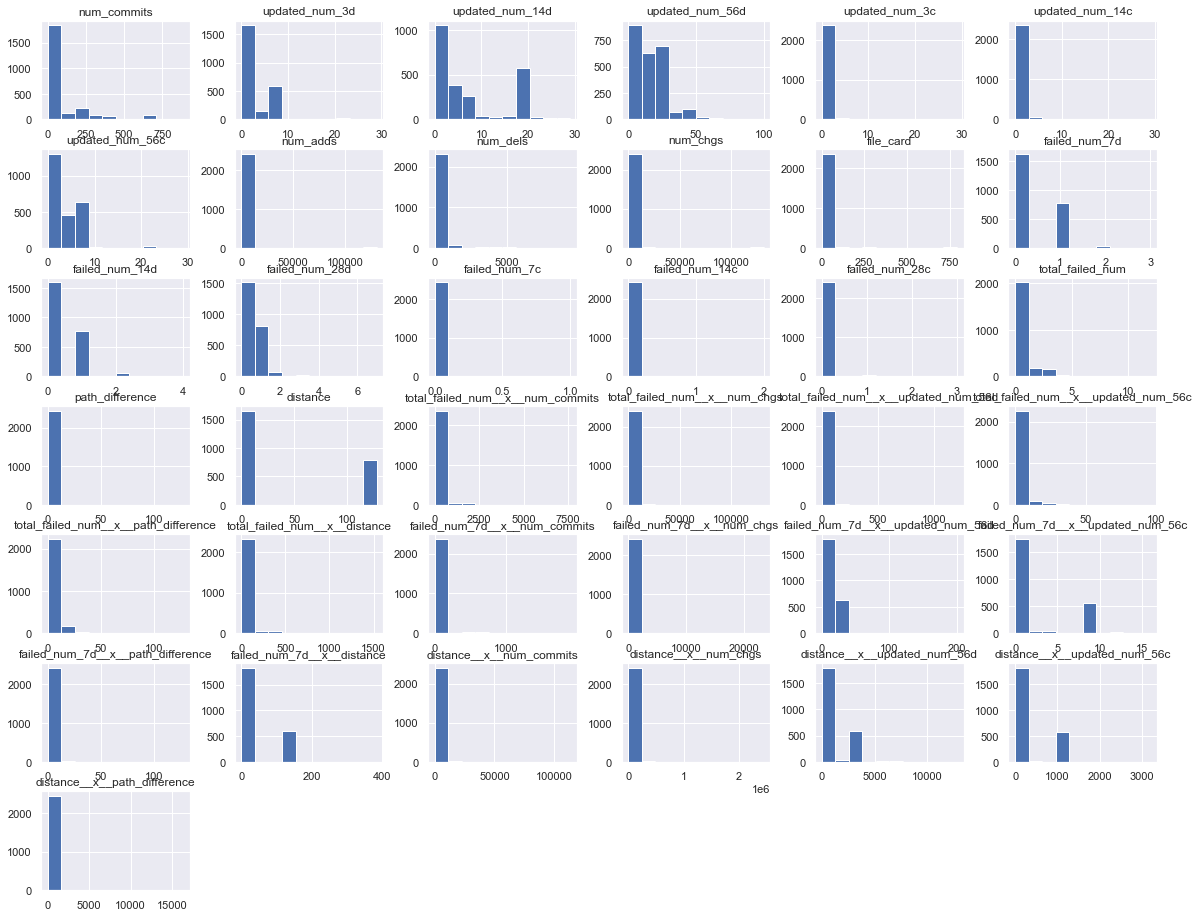

In [36]:
to_histogram_seaborn_numeirc_only(X)

In [37]:
def to_splom_altair(X, target):
    import altair as alt
    chart = alt.Chart(X).mark_circle().encode(
        alt.X(alt.repeat("column"), type='quantitative'),
        alt.Y(alt.repeat("row"), type='quantitative'),
        color=f'{target}:N'
    )
    chart = chart.properties(width=100, height=100)
    chart = chart.repeat(
        row=X.columns.tolist(),
        column=X.columns.tolist()
    )
    return chart

In [38]:
to_splom_altair(pdf, target='failed')

alt.RepeatChart(...)

In [39]:
def to_corr_heatmap(X):    
    import matplotlib.pyplot as plt
    import seaborn as sns
    fig = plt.figure(figsize=(10, 8))
    return sns.heatmap(X.corr(method='pearson'), vmax=1, vmin=-1, center=0, ax=fig.gca())

<AxesSubplot:>

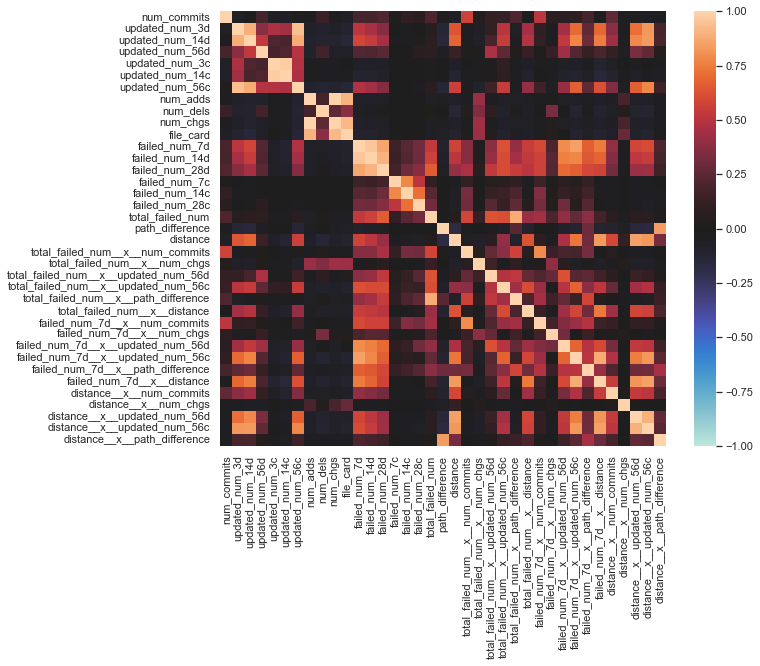

In [40]:
to_corr_heatmap(X)

In [41]:
def compute_mi_between_features(X):
    from minepy import MINE
    results = []
    mine = MINE(alpha=0.6, c=15, est="mic_approx")

    import itertools
    for c1, c2 in itertools.combinations(X.columns, 2):
        mine.compute_score(X[c1], X[c2])
        results.append(((c1, c2), mine.mic()))

    return sorted(results, key=lambda x: x[1], reverse=True)

In [42]:
mi_between_fts = compute_mi_between_features(X)
print(mi_between_fts[0:3])

[(('num_adds', 'num_chgs'), 0.9894901963393762), (('num_commits', 'distance__x__num_commits'), 0.9520692887770721), (('num_chgs', 'file_card'), 0.948472518366191)]


In [43]:
def compute_mi_against(target, X):
    from minepy import MINE
    results = []
    mine = MINE(alpha=0.6, c=15, est="mic_approx")

    for c in X.columns:
        mine.compute_score(y, X[c])
        results.append(((target, c), mine.mic()))

    return sorted(results, key=lambda x: x[1], reverse=True)

In [44]:
mi_against_target = compute_mi_against('failed', X)
selected_features_with_mi = list(map(lambda x: x[0][1], mi_against_target))[0:6]
print(mi_against_target[0:3])

[(('failed', 'failed_num_7d__x__num_chgs'), 0.8241762951638646), (('failed', 'failed_num_7d__x__path_difference'), 0.7755424348926035), (('failed', 'failed_num_7d'), 0.7726189997686731)]


In [45]:
def select_features_with_bruta(X, y, is_discrete=True):
    from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
    from boruta import BorutaPy
    model_class = RandomForestClassifier if is_discrete else RandomForestRegressor
    rf = model_class(n_jobs=-1, max_depth=5)
    rf.fit(X, y)
    print('SCORE with ALL Features: %1.2f' % rf.score(X, y))

    rf = model_class(n_jobs=-1, max_depth=5)
    fs = BorutaPy(rf, n_estimators='auto', random_state=42, perc=80, two_step=False, max_iter=500)
    fs.fit(X.values, y.values)

    selected = fs.support_
    X_selected = X[X.columns[selected]]
    rf = model_class(n_jobs=-1, max_depth=5)
    rf.fit(X_selected, y)
    print('SCORE with selected Features: %1.2f' % rf.score(X_selected, y))
    
    return X.columns[selected]

In [46]:
selected_features_with_bruta = select_features_with_bruta(X, y, is_discrete=True)

SCORE with ALL Features: 0.99
SCORE with selected Features: 0.99


In [47]:
columns_selected = selected_features_with_bruta
# columns_selected = selected_features_with_mi
columns_selected

Index(['num_commits', 'updated_num_3d', 'updated_num_14d', 'updated_num_56d',
       'updated_num_3c', 'updated_num_14c', 'updated_num_56c', 'num_adds',
       'num_dels', 'num_chgs', 'file_card', 'failed_num_7d', 'failed_num_14d',
       'failed_num_28d', 'failed_num_7c', 'failed_num_28c', 'total_failed_num',
       'path_difference', 'distance', 'total_failed_num__x__num_commits',
       'total_failed_num__x__num_chgs', 'total_failed_num__x__updated_num_56d',
       'total_failed_num__x__updated_num_56c',
       'total_failed_num__x__path_difference', 'total_failed_num__x__distance',
       'failed_num_7d__x__num_commits', 'failed_num_7d__x__num_chgs',
       'failed_num_7d__x__updated_num_56d',
       'failed_num_7d__x__updated_num_56c',
       'failed_num_7d__x__path_difference', 'failed_num_7d__x__distance',
       'distance__x__num_commits', 'distance__x__num_chgs',
       'distance__x__updated_num_56d', 'distance__x__updated_num_56c',
       'distance__x__path_difference'],
    

In [48]:
X_selected = X[columns_selected]

In [49]:
def to_pca(X, y, target):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    _X = pca.fit_transform(X)
    _X = pd.DataFrame({'PCA-X': _X[:, 0], 'PCA-Y': _X[:, 1], target: y})

    import matplotlib.pyplot as plt
    import seaborn as sns
    fig = plt.figure(figsize=(10, 8))
    return sns.scatterplot(data=_X, x='PCA-X', y='PCA-Y', hue=target, ax=fig.gca())

<AxesSubplot:xlabel='PCA-X', ylabel='PCA-Y'>

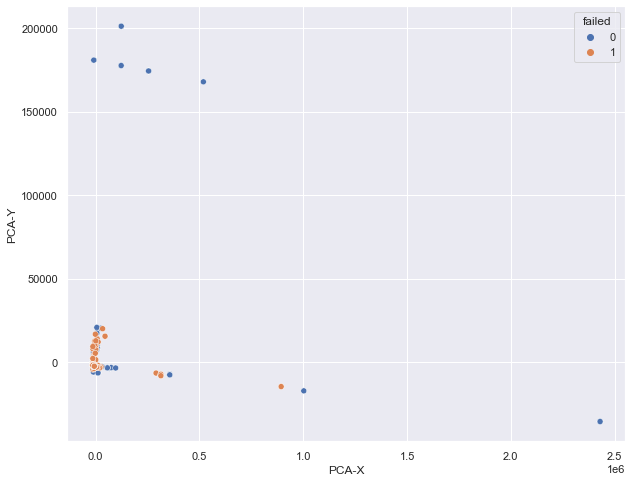

In [50]:
to_pca(X_selected, y, target='failed')

In [51]:
def to_tsne(X, y, target, nsample=100, perplexity=50, n_iter=10000):
    # One of non-linear embedding in sklearn
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=n_iter)
    _pdf = X.copy(deep=True)
    _pdf[target] = y
    _pdf_sampled = _pdf.sample(n=nsample, random_state=42)
    _X = _pdf_sampled[_pdf_sampled.columns[_pdf_sampled.columns != target]]
    _y = _pdf_sampled[target]
    _tf = tsne.fit_transform(_X)
    _X = pd.DataFrame({'tSNE-X': _tf[:, 0], 'tSNE-Y': _tf[:, 1], target: _y})
    print('KL divergence: {}'.format(tsne.kl_divergence_))

    import matplotlib.pyplot as plt
    import seaborn as sns
    fig = plt.figure(figsize=(10, 8))
    return sns.scatterplot(data=_X, x='tSNE-X', y='tSNE-Y', hue=target, ax=fig.gca())

KL divergence: 0.15166325867176056


<AxesSubplot:xlabel='tSNE-X', ylabel='tSNE-Y'>

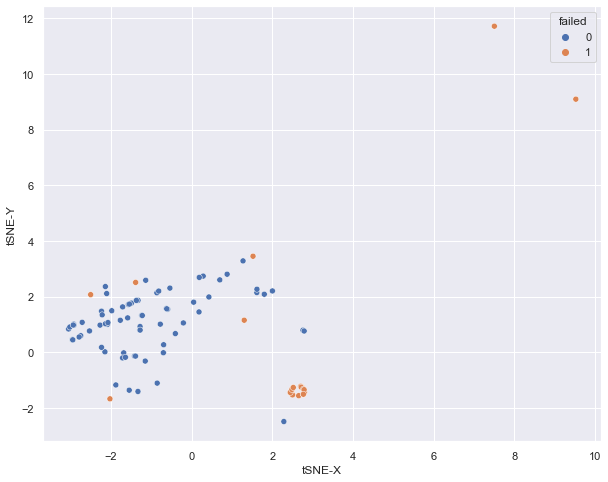

In [52]:
to_tsne(X_selected, y, target='failed', nsample=100, perplexity=50, n_iter=10000)

In [53]:
def to_umap(X, y, target, n_neighbors=5, min_dist=0.3, metric='euclidean'):
    from umap import UMAP
    umap = UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric)
    _data = umap.fit_transform(X)
    _X = pd.DataFrame({'tSNE-X': _data[:, 0], 'tSNE-Y': _data[:, 1], target: y})

    import altair as alt
    chart = alt.Chart(_X).mark_point().encode(x='tSNE-X', y='tSNE-Y', color=f'{target}:N').properties(width=600, height=400).interactive()
    return chart

In [54]:
to_umap(X_selected, y, target='failed', n_neighbors=300, min_dist=1.0, metric='euclidean')

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


alt.Chart(...)

In [55]:
def reduce_dim(X, y, target, n_components=2, n_neighbors=5, min_dist=0.3, metric='euclidean'):
    from umap import UMAP
    umap = UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=42)
    _data = umap.fit_transform(X)
    _columns = list(map(lambda x: f'UMAP-{x}', range(0, n_components)))
    return pd.DataFrame(_data, columns=_columns), umap

In [56]:
# X_selected, _ = reduce_dim(X_selected, y, target='failed', n_components=18, n_neighbors=300, min_dist=1.0, metric='euclidean')

In [57]:
from ptesting import train
params = {'hp.timeout': '3600', 'hp.no_progress_loss': '10'}
clf, score = train.build_model(X_selected, y, opts=params)
print(f'Score: {score}')

Score: 0.9842804375691564


In [138]:
probs = clf.predict_proba(test_pdf[columns_selected])
pmf = map(lambda p: {"classes": clf.classes_.tolist(), "probs": p.tolist()}, probs)
pmf = map(lambda p: json.dumps(p), pmf)
df = spark.createDataFrame(pd.DataFrame({'sha': test_pdf['sha'], 'test': test_pdf['test'], 'pmf': list(pmf)}))
df = df.selectExpr('sha', 'test', 'from_json(pmf, "classes array<string>, probs array<double>") pmf')
df = df.selectExpr('sha', 'test', 'map_from_arrays(pmf.classes, pmf.probs) pmf')
df = df.selectExpr('sha', 'test', 'pmf["1"] failed_prob', 'pmf["1"] >= 0.50 predicted')
df = df.join(test_df, 'sha', 'INNER').selectExpr('sha', 'test', 'failed_prob', 'size(failed_tests) > 0 failed', 'predicted', 'failed_tests')

In [139]:
df.show(3, 150)

+----------------------------------------+----------------------------------------------------------+-------------------+------+---------+------------+
|                                     sha|                                                      test|        failed_prob|failed|predicted|failed_tests|
+----------------------------------------+----------------------------------------------------------+-------------------+------+---------+------------+
|2e2283de4b77fd407935ff074e0f465b73cbc7c4|      org.apache.spark.sql.hive.execution.HiveCommandSuite| 0.3873828032335693| false|    false|          []|
|2e2283de4b77fd407935ff074e0f465b73cbc7c4|org.apache.spark.sql.catalyst.expressions.ComplexTypeSuite|0.28031410560583286| false|    false|          []|
|2e2283de4b77fd407935ff074e0f465b73cbc7c4|          org.apache.spark.sql.HiveCharVarcharDDLTestSuite| 0.3975005699258023| false|    false|          []|
+----------------------------------------+----------------------------------------------

<AxesSubplot:>

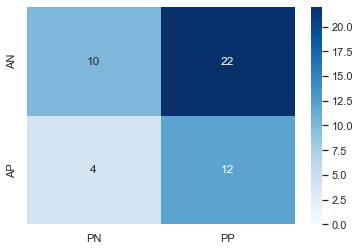

In [130]:
prob_thres = 0.50
predicted_pdf = df.groupBy('sha').agg(f.expr('first(failed) failed'), f.expr('array_max(collect_set(failed_prob)) failed_prob')).selectExpr('failed', f'failed_prob >= {prob_thres} predicted', 'failed_prob').toPandas()

import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predicted_pdf['failed'], predicted_pdf['predicted'])
sns.heatmap(pd.DataFrame(cm, index=['AN', 'AP'], columns=['PN', 'PP']), annot=True, cmap='Blues', vmin=0)

In [131]:
from sklearn.metrics import classification_report
pd.DataFrame(classification_report(predicted_pdf['failed'], predicted_pdf['predicted'], target_names=['passed', 'failed'], output_dict=True))

,passed,failed,accuracy,macro avg,weighted avg
precision,0.714286,0.352941,0.458333,0.533613,0.593838
recall,0.312500,0.750000,0.458333,0.531250,0.458333
f1-score,0.434783,0.480000,0.458333,0.457391,0.449855
support,32.000000,16.000000,0.458333,48.000000,48.000000


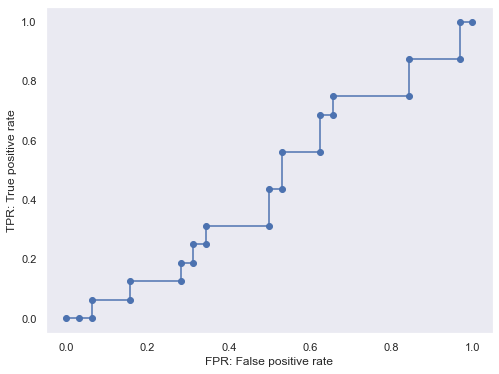

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve

fpr, tpr, thres = roc_curve(predicted_pdf['failed'], predicted_pdf['failed_prob'])

sns.set()
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

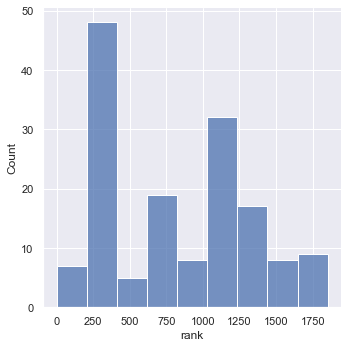

In [155]:
rank_df = df.groupBy('sha').agg(f.expr('first(failed_tests) failed_tests'), f.expr('collect_set(named_struct("t", test, "p", failed_prob)) tests'))
rank_df = rank_df.selectExpr('sha', 'explode(failed_tests) failed_test', 'array_sort(tests, (l, r) -> case when l.p < r.p then 1 when l.p > r.p then -1 else 0 end) tests')
rank_df = rank_df.selectExpr('sha', 'failed_test', 'tests.t tests').selectExpr('sha', 'failed_test', 'array_position(tests, failed_test) rank')
rank_pdf = rank_df.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns
sns.displot(rank_pdf, x="rank")